In [1]:
from model_arch import MultitaskModel
from utils import prepare_data, train_model, evaluate_model, evaluate_test_data, plot_losses

import os
import copy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# Read Data

In [2]:
curr_dir = os.getcwd()

train = pd.read_parquet(os.path.join(curr_dir, "data/train.parquet"))
val = pd.read_parquet(os.path.join(curr_dir, "data/val.parquet"))
test = pd.read_parquet(os.path.join(curr_dir, "data/test.parquet"))

# Baseline - Random Forest

In [160]:
def prepare_data_for_rf(df: pd.DataFrame) -> tuple:
    cols = [c for c in df.columns if "dim" in c] + ["open"]
    df2 = df.drop(columns=["if_higher", "stock_name", "tweet", "company_name", "date", 'open_target',
                              'high_target', 'low_target', 'close_target',
                              'adj_close_target', 'volume_target'])
    X = df2[cols]
    y_reg = df.close_target.tolist()
    y_cls = df.if_higher.tolist()
    return X, y_reg, y_cls

In [161]:
X_train, y_reg_train, y_cls_train = prepare_data_for_rf(train)
X_val, y_reg_val, y_cls_val = prepare_data_for_rf(val)
X_test, y_reg_test, y_cls_test = prepare_data_for_rf(test)

## Regressor

In [163]:
# training regressor
reg = RandomForestRegressor()
reg.fit(X_train, y_reg_train)
y_train_pred = reg.predict(X_train)

In [164]:
y_val_pred = reg.predict(X_val)
y_test_pred = reg.predict(X_test)
print("Train error", mean_squared_error(y_reg_train, y_train_pred))
print("Val error", mean_squared_error(y_reg_val, y_val_pred))
print("Test error", mean_squared_error(y_reg_test, y_test_pred))

Train error 12.853029718953776
Val error 50.53638275913058
Test error 1336.4394978337311


## Classifier

In [165]:
# training regressor
reg = RandomForestClassifier()
reg.fit(X_train, y_cls_train)
y_train_pred = reg.predict(X_train)

In [166]:
y_val_pred = reg.predict(X_val)
y_test_pred = reg.predict(X_test)
print("Train error", accuracy_score(y_cls_train, y_train_pred))
print("Val error", accuracy_score(y_cls_val, y_val_pred))
print("Test error", accuracy_score(y_cls_test, y_test_pred))

Train error 1.0
Val error 0.5358851674641149
Test error 0.4630071599045346


# Muli-task Learning Deep Neural Networks

In [3]:
# Main script
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 20

    train_ds = prepare_data(train)
    val_ds = prepare_data(val)
    test_ds = prepare_data(test)
    
    batch_size = 32
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Initialize model, loss functions, and optimizer
    model = MultitaskModel()
    criterion_reg = nn.MSELoss()  # Loss for regression
    criterion_class = nn.BCELoss()  # Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model and validate
    best_val_loss = float('-inf')
    best_epoch = 0
    total_train_loss = []
    total_val_loss = []

    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion_reg, criterion_class, optimizer, num_epochs, epoch)
        val_loss = evaluate_model(model, val_loader, criterion_reg, criterion_class)

        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
        
        if val_loss > best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_weights = copy.deepcopy(model.state_dict())
    
    print("best epoch: {} best val loss: {:.4f}".format(best_epoch, best_val_loss))
    model.load_state_dict(best_weights)
    test_loss = evaluate_model(model, test_loader, criterion_reg, criterion_class)

    #print(f"Validation Loss: {val_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")



Epoch [1/20], Loss: 21029.7396
Epoch [2/20], Loss: 176.8088
Epoch [3/20], Loss: 59.9349
Epoch [4/20], Loss: 59.6975
Epoch [5/20], Loss: 58.8204
Epoch [6/20], Loss: 59.0867
Epoch [7/20], Loss: 61.8766
Epoch [8/20], Loss: 60.3664
Epoch [9/20], Loss: 65.7406
Epoch [10/20], Loss: 65.4770
Epoch [11/20], Loss: 61.8591
Epoch [12/20], Loss: 61.3493
Epoch [13/20], Loss: 61.9283
Epoch [14/20], Loss: 60.0801
Epoch [15/20], Loss: 60.4644
Epoch [16/20], Loss: 63.1937
Epoch [17/20], Loss: 62.5648
Epoch [18/20], Loss: 60.1607
Epoch [19/20], Loss: 60.8489
Epoch [20/20], Loss: 61.1129
best epoch: 0 best val loss: 598.5045
Test Loss: 3087.9433


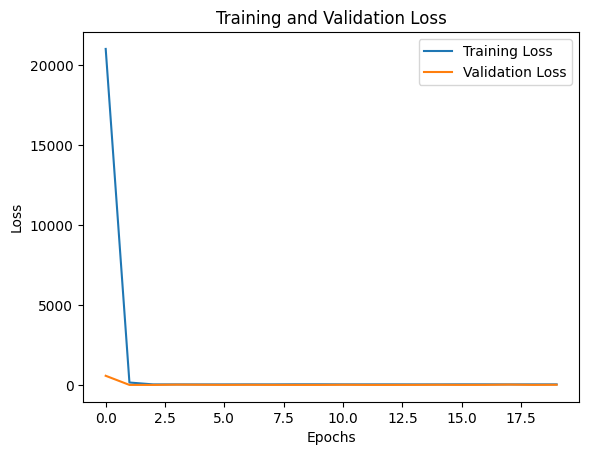

In [4]:
# Plot train and validation loss
plot_losses(total_train_loss, total_val_loss)

# Evaluate Test

In [9]:
evaluate_test_data(test_loader, model)

root_mean_squared_error for test 42.339836
f1 score for test 0.7027863777089783


# Save Model

In [182]:
torch.save(model.state_dict(), os.path.join(curr_dir, "artifact/model.pth"))